### Feature Engineering in Healthcare Fraud Detection Notebook

#### Main Concepts:

Feature engineering is a critical step in machine learning pipelines, aimed at improving the model's performance. In the notebook, various feature engineering techniques are applied to the healthcare fraud detection dataset.

#### Technical Details:

1. **Normalization of Categorical Values**: 
    - The `RenalDiseaseIndicator` column has its 'Y' values replaced with 1.
    - Chronic condition columns (`ChronicCond_`) have their value 2 replaced with 0, effectively binarizing these features.

2. **Handling Missing Values**: 
    - The `DeductibleAmtPaid` column's missing values are filled with 0.

3. **Dropping Irrelevant Columns**: 
    - Columns having all null values are dropped from the dataset.

4. **Class Label Encoding**: 
    - The `PotentialFraud` column is converted to numerical format, replacing 'Yes' with 1 and 'No' with 0.

#### Resulting Data:

The dataset, after these feature engineering steps, would be more suited for machine learning algorithms. Features are either normalized or appropriately encoded, and missing values are handled. The dataset's shape is logged, but the exact dimensions are not visible in the initial code cells.

#### Review and Corrections:

The summary is based on the code cells where 'feature' was mentioned. For a more comprehensive understanding, the entire notebook would need to be analyzed.

#### Conclusion:

The notebook applies a range of feature engineering techniques aimed at preparing the healthcare fraud detection dataset for further analysis and model training. These steps are crucial for any machine learning pipeline and are well-executed in the notebook.

In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

In [2]:
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

In [3]:
%%time
'''
Dataset
'''
dataProvider = pd.read_csv('Data/Train-1542865627584.csv') # Mapping Dataset
dataBeneficiary = pd.read_csv('Data/Train_Beneficiarydata-1542865627584.csv') # Beneficiary Dataset
dataInpatient = pd.read_csv('Data/Train_Inpatientdata-1542865627584.csv') # Inpatient Dataset
dataOutpatient = pd.read_csv('Data/Train_Outpatientdata-1542865627584.csv') # Outpatient Dataset

CPU times: total: 1.03 s
Wall time: 1.28 s


In [4]:
def combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient):
    '''
    Combines the given datasets of Provider Class Label mapping, Beneficiary data, Inpatient and Outpatient claims data,
    and returns the combined dataset.
    
    Parameters:
    ----------
    dataProvider: pandas.core.frame.DataFrame
        DataFrame containing the Provider Unique Identifier and Class Label (in case of Train data).
    dataBeneficiary: pandas.core.frame.DataFrame
        DataFrame containing the Beneficiary related data
    dataInpatient: pandas.core.frame.DataFrame
        DataFrame containing the Inpatient claims related data
    dataOutpatient: pandas.core.frame.DataFrame
        DataFrame containing the Outpatient claims related data        
    '''
    
    # Concatenate the Inpatient and Outpatient dataset as these contain almost similar information
    dataConcat = pd.concat([dataInpatient, dataOutpatient])
    
    # Merge the above dataframe with the Beneficiary dataframe
    dataMerge = pd.merge(left=dataConcat, right=dataBeneficiary, on='BeneID')
    
    # Merge the above dataframe with the provider dataframe to add the Class Label.
    dataFinal = pd.merge(left=dataMerge, right=dataProvider, on='Provider')
    
    # Return the final dataframe
    return dataFinal

In [5]:
%%time
# Call the function 'combineDatasets' for the datasets.
data = combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient)

CPU times: total: 609 ms
Wall time: 806 ms


In [6]:
print('Shape of the merged Dataset: ', data.shape)
print('Number of features in the merged Dataset: ', data.shape[1]-1)

Shape of the merged Dataset:  (558211, 55)
Number of features in the merged Dataset:  54


In [7]:
data.info() # Print a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   AdmissionDt                      40474 non-null   object 
 10  ClmAdmitDiagnosisCode            145899 non-null  object 
 11  DeductibleAmtPaid                557312 non-null  float64
 12  Di

In [8]:
from sklearn.impute import KNNImputer

In [9]:

def dataCleanup(data):
    '''
    Cleans up the data in the given dataset and returns the cleaned dataset.
    This has been written by doing the analysis of each individual column values.
    TODO: Any kind of imputation is not done as part of this method and it will done by doing nvariate analysis of the 
    columns having null values.
    
    Parameter:
    ---------
    data: pandas.core.frame.DataFrame
        Dataframe to be cleaned up
    '''
    
    # -------------------------------Region : Beneficiary Columns-------------------------------------------------
    
    # 'Renal Disease Indicator' column.
    # RenalDiseaseIndicator column has two unique values: 0 and 'Y'. Replace the value of 'Y' with 1.
    data['RenalDiseaseIndicator'].replace(to_replace='Y', value=1, inplace=True)
    
    # 'Chronic Condition' columns
    # 'ChronicCond_' columns contains two unique values: 1 and 2. Replace the value of 2 with 0 to indicate 1 as 'Yes' 
    # and 0 as 'No'
    for chronicCol in [col for col in list(data.columns) if 'Chronic' in col]:
        data[chronicCol].replace(to_replace=2, value=0, inplace=True)

    
    # Fill empty values of the 'DeductibleAmtPaid' feature as it is a numeric feature and has some empty values.
    # Create an instance of KNNImputer with n_neighbors=5
    imputer = KNNImputer(n_neighbors=5)
    # Fit the imputer on the 'DeductibleAmtPaid' column
    data['DeductibleAmtPaid'] = imputer.fit_transform(data['DeductibleAmtPaid'].values.reshape(-1,1))

    

    # Drop the columns having all null values
    data.dropna(axis=1, how='all', inplace=True)
    
    # Replace the class label 'PotentialFraud' values. Replace 'Yes' with 1 and 'No' with 0.
    if ('PotentialFraud' in data.columns):
        
        data['PotentialFraud'].replace(to_replace=['Yes', 'No'], value=[1, 0], inplace=True)


In [10]:
%%time
# Call the function 'dataCleanup' to clean the data in the dataframe
dataCleanup(data)

CPU times: total: 28.8 s
Wall time: 14.5 s


In [11]:
print('Shape of the Dataset: ', data.shape)

Shape of the Dataset:  (558211, 54)


In [12]:
print('Percentage of missing values in the Dataframe (column wise):\n')
round((data.isna().sum()/data.shape[0])*100,2)

Percentage of missing values in the Dataframe (column wise):



BeneID                               0.00
ClaimID                              0.00
ClaimStartDt                         0.00
ClaimEndDt                           0.00
Provider                             0.00
InscClaimAmtReimbursed               0.00
AttendingPhysician                   0.27
OperatingPhysician                  79.50
OtherPhysician                      64.22
AdmissionDt                         92.75
ClmAdmitDiagnosisCode               73.86
DeductibleAmtPaid                    0.00
DischargeDt                         92.75
DiagnosisGroupCode                  92.75
ClmDiagnosisCode_1                   1.87
ClmDiagnosisCode_2                  35.04
ClmDiagnosisCode_3                  56.46
ClmDiagnosisCode_4                  70.52
ClmDiagnosisCode_5                  79.95
ClmDiagnosisCode_6                  84.88
ClmDiagnosisCode_7                  88.14
ClmDiagnosisCode_8                  90.43
ClmDiagnosisCode_9                  92.51
ClmDiagnosisCode_10               

In [13]:
# Set of columns to be removed
columnsToRemove = ['ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5']
# Remove the above set of columns from the dataframe
data.drop(columns=columnsToRemove, inplace=True)
print('Shape of the Dataset after removal of columns having more than 99% empty values: ', data.shape)

Shape of the Dataset after removal of columns having more than 99% empty values:  (558211, 51)


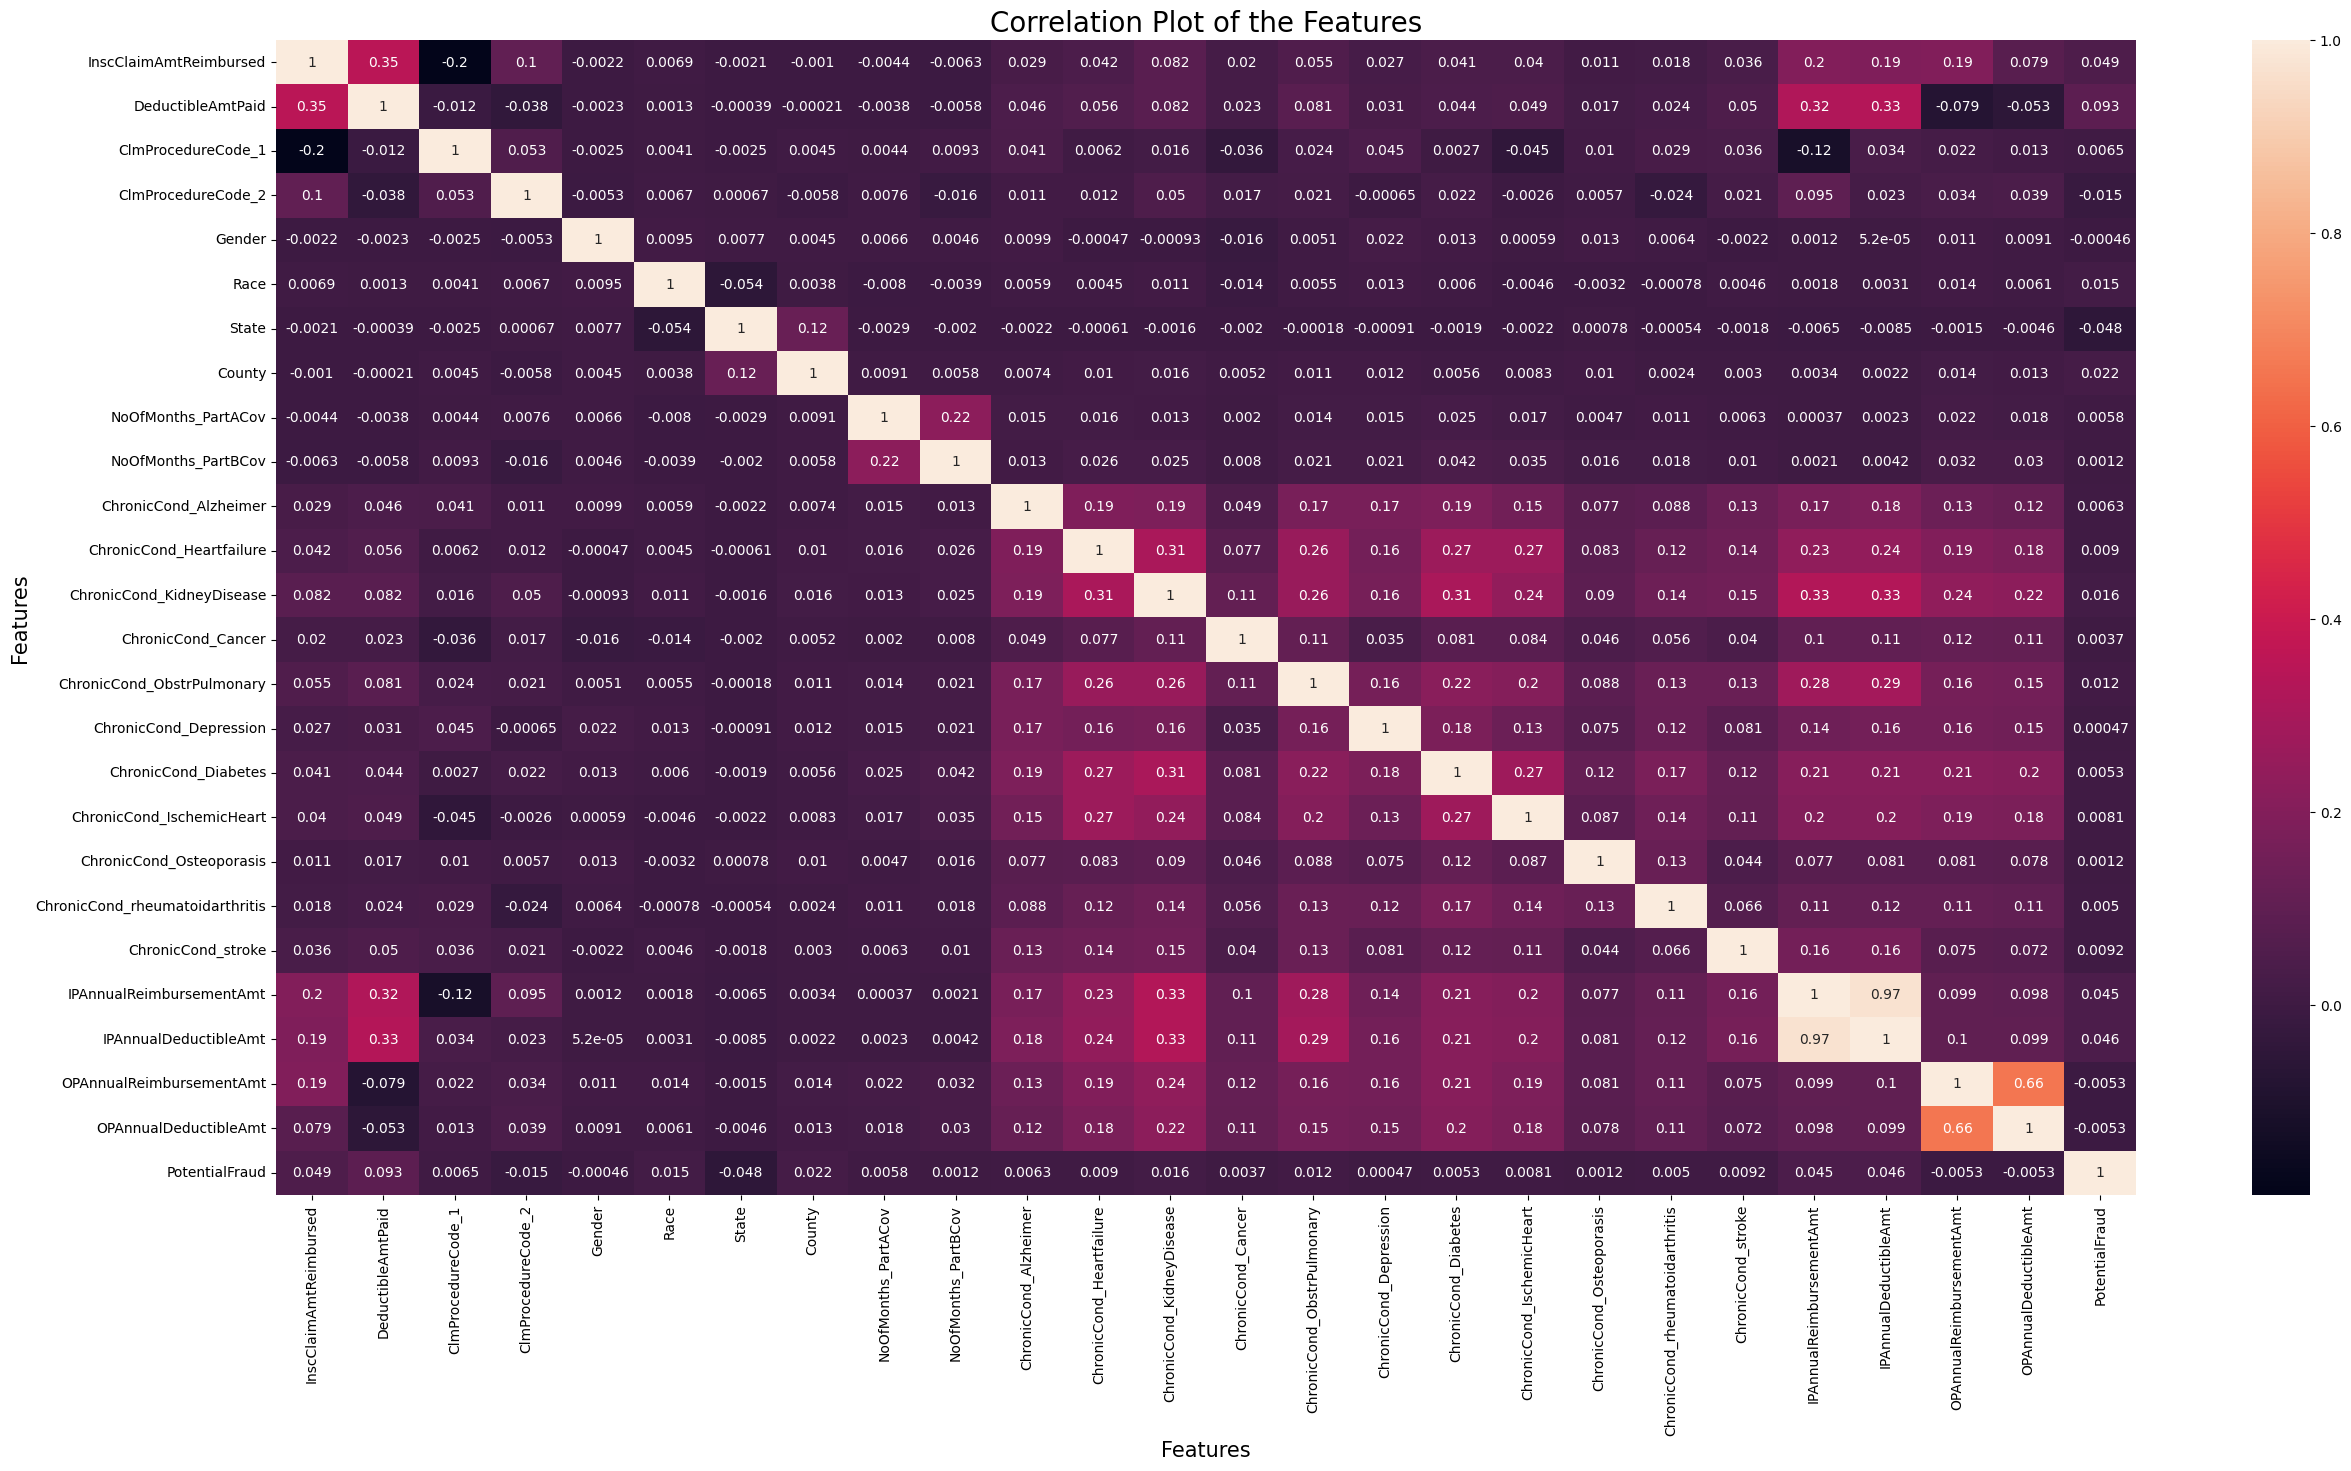

CPU times: total: 2.72 s
Wall time: 3.22 s


In [14]:
%%time
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

In [15]:
data.corr(method='spearman')

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
InscClaimAmtReimbursed,1.000000,0.353070,-0.196469,0.103665,-0.002233,0.006928,-0.002093,-0.001038,-0.004354,-0.006337,...,0.041370,0.040323,0.010999,0.017612,0.036256,0.196339,0.191347,0.192241,0.078592,0.048673
DeductibleAmtPaid,0.353070,1.000000,-0.012367,-0.037947,-0.002324,0.001334,-0.000394,-0.000214,-0.003828,-0.005822,...,0.044308,0.048834,0.017008,0.023909,0.050131,0.322940,0.331757,-0.079408,-0.052671,0.093098
ClmProcedureCode_1,-0.196469,-0.012367,1.000000,0.053269,-0.002525,0.004074,-0.002462,0.004526,0.004407,0.009298,...,0.002679,-0.045166,0.010499,0.028669,0.036064,-0.118272,0.033887,0.022357,0.013275,0.006483
ClmProcedureCode_2,0.103665,-0.037947,0.053269,1.000000,-0.005293,0.006651,0.000666,-0.005755,0.007628,-0.016023,...,0.022478,-0.002625,0.005671,-0.024253,0.021451,0.095494,0.022966,0.033868,0.038753,-0.014596
Gender,-0.002233,-0.002324,-0.002525,-0.005293,1.000000,0.009533,0.007675,0.004507,0.006563,0.004623,...,0.013396,0.000593,0.013263,0.006398,-0.002173,0.001207,0.000052,0.011119,0.009064,-0.000460
Race,0.006928,0.001334,0.004074,0.006651,0.009533,1.000000,-0.054112,0.003751,-0.007960,-0.003904,...,0.005996,-0.004564,-0.003162,-0.000784,0.004579,0.001800,0.003081,0.013622,0.006133,0.014978
State,-0.002093,-0.000394,-0.002462,0.000666,0.007675,-0.054112,1.000000,0.121375,-0.002930,-0.002008,...,-0.001854,-0.002198,0.000785,-0.000542,-0.001763,-0.006450,-0.008522,-0.001461,-0.004567,-0.047616
County,-0.001038,-0.000214,0.004526,-0.005755,0.004507,0.003751,0.121375,1.000000,0.009150,0.005765,...,0.005625,0.008284,0.010297,0.002429,0.002998,0.003359,0.002193,0.014232,0.013459,0.022105
NoOfMonths_PartACov,-0.004354,-0.003828,0.004407,0.007628,0.006563,-0.007960,-0.002930,0.009150,1.000000,0.224272,...,0.025281,0.017017,0.004704,0.010639,0.006310,0.000371,0.002277,0.021903,0.017545,0.005754
NoOfMonths_PartBCov,-0.006337,-0.005822,0.009298,-0.016023,0.004623,-0.003904,-0.002008,0.005765,0.224272,1.000000,...,0.041530,0.034620,0.015612,0.017798,0.010158,0.002076,0.004190,0.031731,0.030304,0.001171


### date


In [16]:
# Date related columns
colDate = [col for col in data.columns if ('Dt' in col or 'DOB' in col or 'DOD' in col)]

print('Date related columns: ', colDate)

Date related columns:  ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']


In [17]:
# Convert these columns to DateTime Format
data[colDate] = data[colDate].apply(pd.to_datetime)

In [18]:
# Generate new Feature 'ClaimSettlementDelay' (ClaimEndDt - ClaimStartDt)
data['ClaimSettlementDelay'] = (data['ClaimEndDt'] - data['ClaimStartDt']).dt.days

In [19]:
# Generate new Feature 'TreatmentDuration' (DischargeDt - AdmissionDt)
data['TreatmentDuration'] = (data['DischargeDt'] - data['AdmissionDt']).dt.days
data['TreatmentDuration'].fillna(0, inplace=True) # Filling empty values with 0 because the features 
# 'DischargeDt' and 'AdmissionDt' exist only for Inpatient records.

data['TreatmentDuration'] = data['TreatmentDuration'].apply(int)

In [20]:
maxDate = max(data['ClaimEndDt'].max(), data['DischargeDt'].max())
print('Maximum Claim End Date or Discharge Date: ', maxDate)

Maximum Claim End Date or Discharge Date:  2009-12-31 00:00:00


In [21]:
%%time
data['Age'] = data.apply(lambda x: round(((x['DOD'] - x['DOB']).days)/365) if pd.notnull(x['DOD'])
                         else round(((maxDate - x['DOB']).days)/365), axis=1)

CPU times: total: 7.8 s
Wall time: 8.99 s


In [22]:
%%time
# Generate new Feature 'IsDead' based on whether there is a value in the DOD column or not
data['IsDead'] = data['DOD'].apply(lambda x: 1 if pd.notnull(x) else 0)

CPU times: total: 172 ms
Wall time: 254 ms


In [23]:
# Remove the set of date columns from the dataframe
data.drop(columns=colDate, inplace=True)

In [24]:
print('Shape of the Dataset after removal of date features and addition of new features: ', data.shape)

Shape of the Dataset after removal of date features and addition of new features:  (558211, 49)


In [36]:
data.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,...,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimSettlementDelay,TreatmentDuration,Age,IsDead
0,BENE11001,CLM46614,PRV55912,26000,PHY390922,NaN,NaN,7866,1068.0,201,...,1,36000,3204,60,70,1,6,6,67,0
1,BENE16973,CLM565430,PRV55912,50,PHY365867,PHY327147,NaN,NaN,0.0,NaN,...,0,24000,2136,450,200,1,0,0,78,0
2,BENE17521,CLM34721,PRV55912,19000,PHY349293,PHY370861,PHY363291,45340,1068.0,987,...,0,19000,1068,100,20,1,12,12,96,0
3,BENE21718,CLM72336,PRV55912,17000,PHY334706,PHY334706,NaN,V5789,1068.0,941,...,0,17000,1068,1050,540,1,18,18,87,0
4,BENE22934,CLM73394,PRV55912,13000,PHY390614,PHY323689,PHY363291,71946,1068.0,506,...,0,27000,2136,450,160,1,4,4,80,0


In [37]:
# Fetch the features related to amount.
colAmt = [col for col in data.columns if 'Amt' in col]
colAmt

['InscClaimAmtReimbursed',
 'DeductibleAmtPaid',
 'IPAnnualReimbursementAmt',
 'IPAnnualDeductibleAmt',
 'OPAnnualReimbursementAmt',
 'OPAnnualDeductibleAmt']

In [38]:
# Total Claim Amount = Insurance Claim Amount reimbursed + Deductible Amount paid by the Subscriber
data['TotalClaimAmount'] = data['InscClaimAmtReimbursed'] + data['DeductibleAmtPaid']

# Total Inpatient Amount = Inpatient Annual Amount reimbursed + Inpatient Annual Deductible Amount
data['IPTotalAmount'] = data['IPAnnualReimbursementAmt'] + data['IPAnnualDeductibleAmt']

# Total Outpatient Amount = Outpatient Annual Amount reimbursed + Outpatient Annual Deductible Amount
data['OPTotalAmount'] = data['OPAnnualReimbursementAmt'] + data['OPAnnualDeductibleAmt']

In [39]:
# Remove the set of old amount features from the dataframe
data.drop(columns=colAmt, inplace=True)

In [40]:
print('Shape of the Dataset after removal of old amount related features and addition of new features: ', data.shape)

Shape of the Dataset after removal of old amount related features and addition of new features:  (558211, 46)


In [41]:
# new feature called 'IsInpatient' having value 1 if the claim record is for Inpatient data and 0 if the claim record is for Outpatient data
data['IsInpatient'] = data['DiagnosisGroupCode'].apply(lambda x: 1 if pd.notnull(x) else 0)

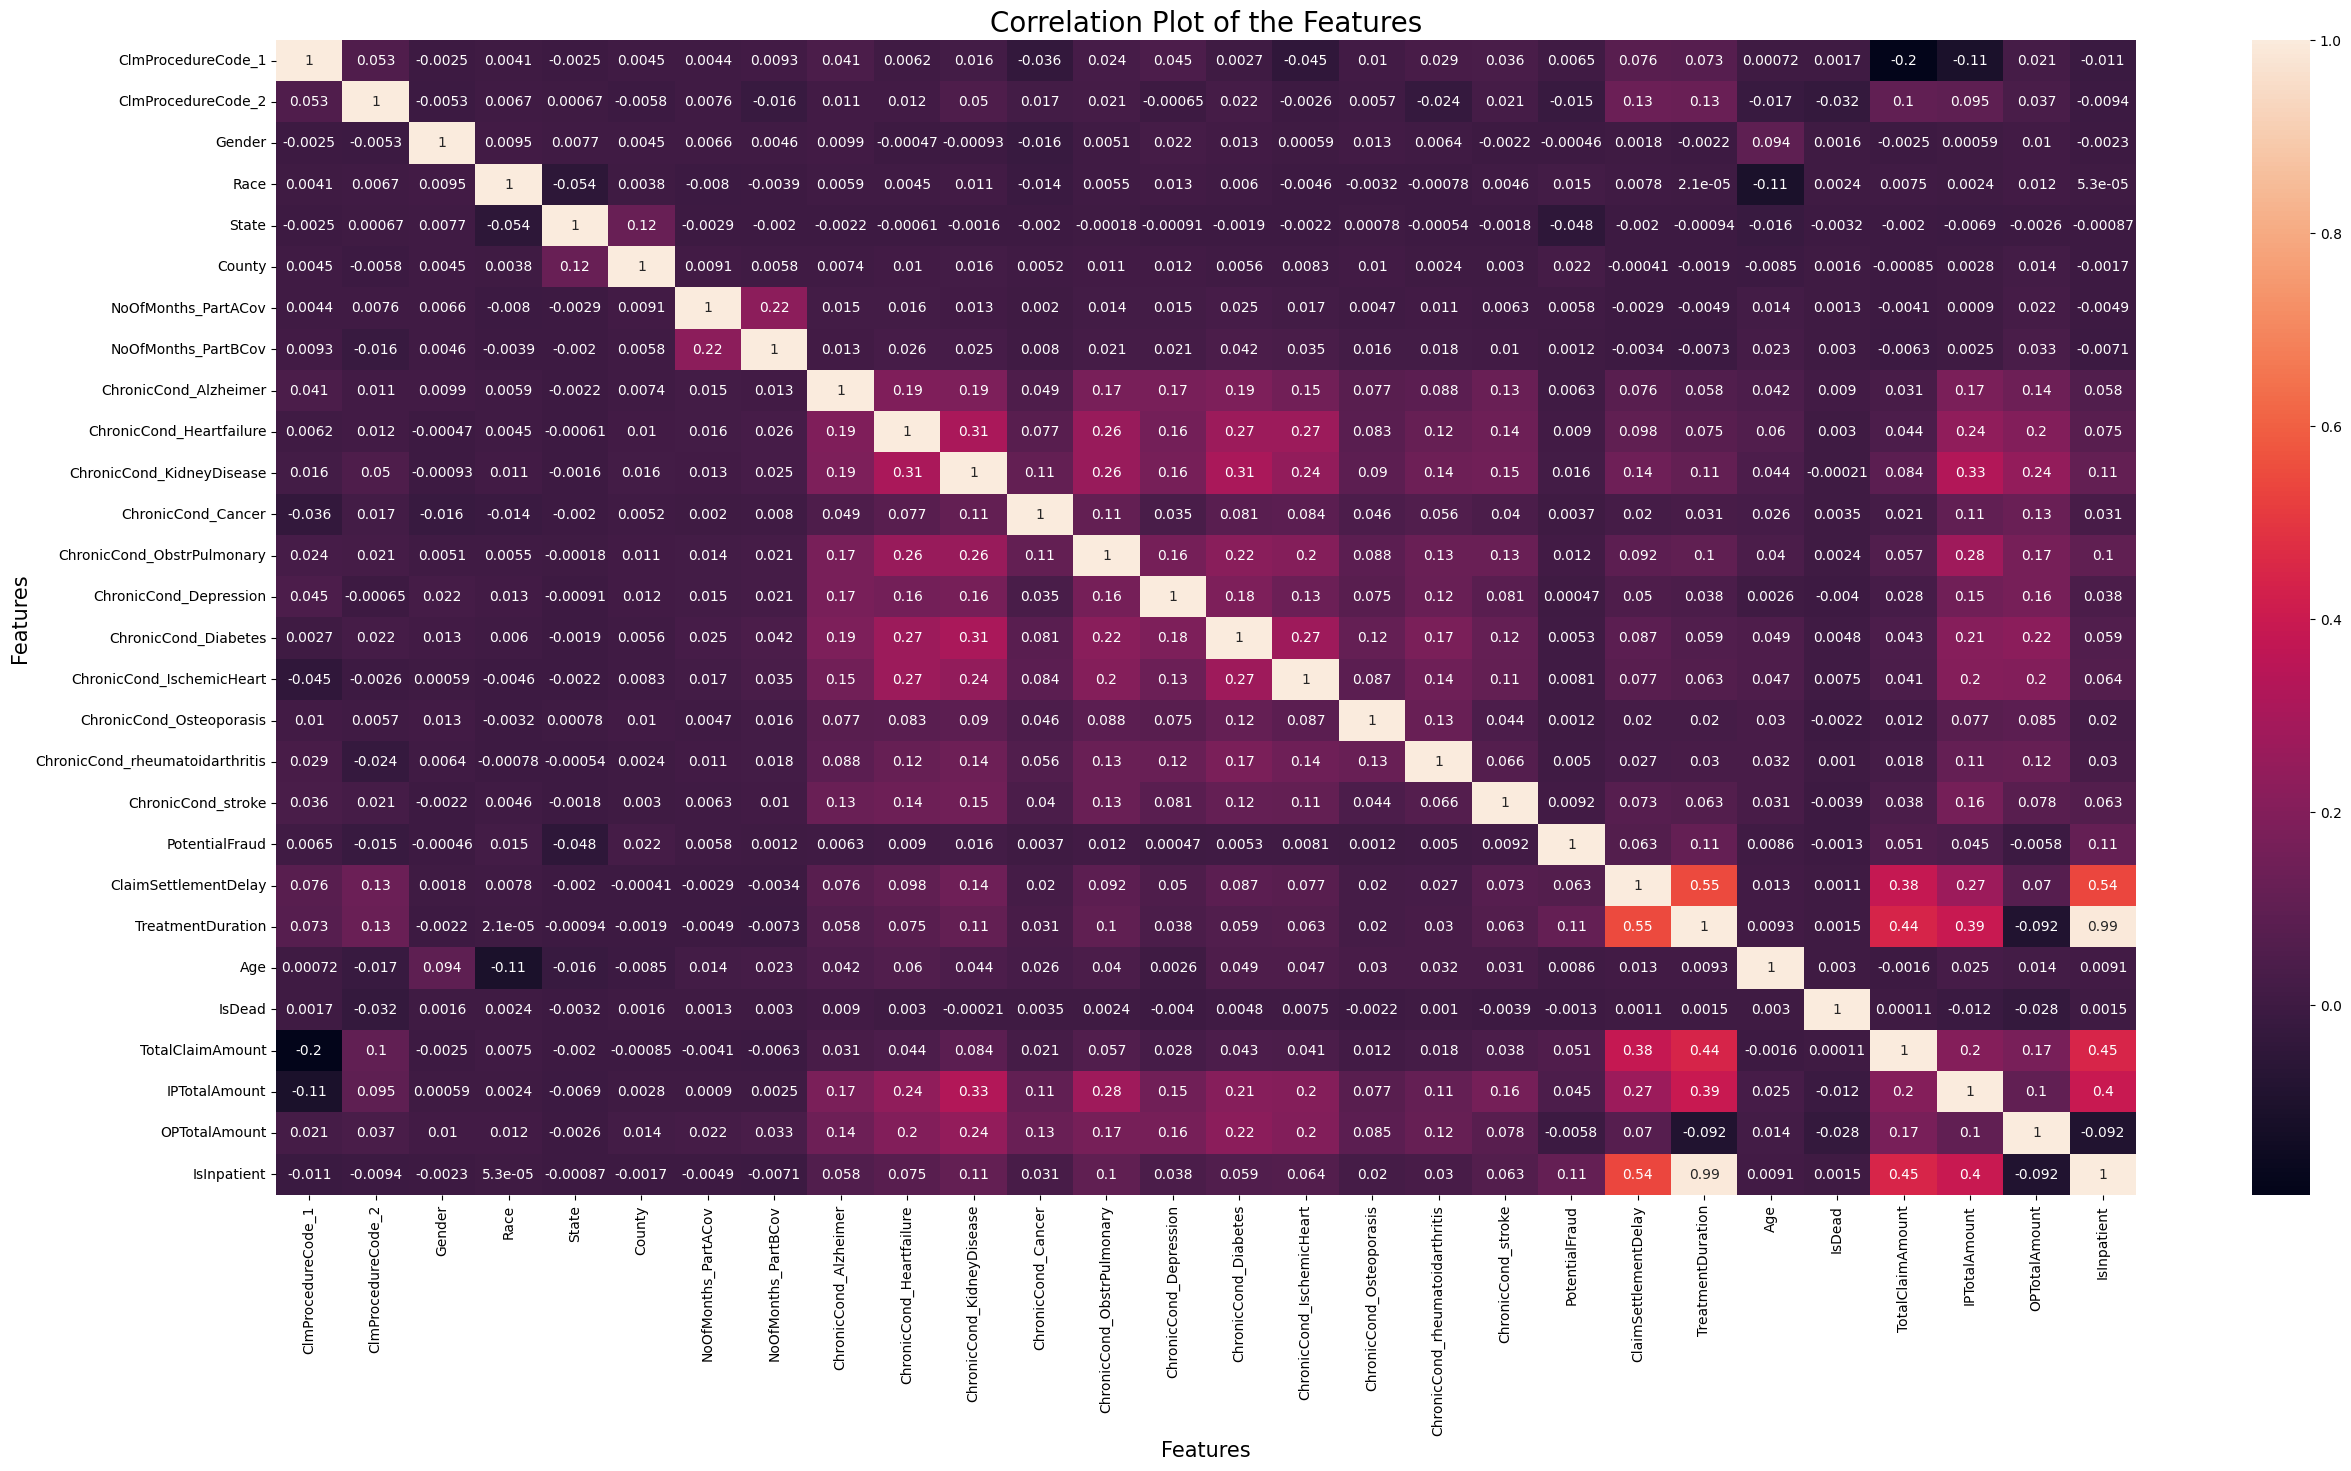

CPU times: total: 2.56 s
Wall time: 3.73 s


In [42]:
%%time
# Plotting the correlation Plot to see the correlated features
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

In [44]:
# The features 'IsInpatient' and 'TreatmentDuration' are highly correlated with a Spearman Rank Correlation Coefficient of 0.99.
data.drop(columns='IsInpatient', inplace=True)

In [45]:
data.drop(columns=['ClaimID', 'BeneID', 'Provider', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], inplace=True)

In [46]:
print('Shape of the Dataframe:', data.shape)

Shape of the Dataframe: (558211, 41)


In [47]:
# Fetch the columns related to Physicians
colPhys = [col for col in data.columns if 'Physician' in col]

colPhys

['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

In [48]:
%%time
# Prepare the feature 'UniquePhysCount'
data['UniquePhysCount'] = data[colPhys].apply(lambda x: len(set([phys for phys in x if not pd.isnull(phys)])), axis=1)

CPU times: total: 2.12 s
Wall time: 2.82 s


In [49]:
%%time
# Prepare the feature 'PhysRoleCount'
data['PhysRoleCount'] = data[colPhys].apply(lambda x: len([phys for phys in x if not pd.isnull(phys)]), axis=1)

CPU times: total: 2.09 s
Wall time: 2.76 s


In [50]:
%%time
# Prepare the feature 'IsSamePhysMultiRole1'
data['IsSamePhysMultiRole1'] = data[['UniquePhysCount','PhysRoleCount']] \
                                .apply(lambda x: 1 if x['UniquePhysCount'] == 1 and x['PhysRoleCount'] > 1 else 0, axis=1)

CPU times: total: 2.64 s
Wall time: 3.07 s


In [51]:
%%time
# Prepare the feature 'IsSamePhysMultiRole2'
data['IsSamePhysMultiRole2'] = data[['UniquePhysCount','PhysRoleCount']] \
                                .apply(lambda x: 1 if x['UniquePhysCount'] == 2 and x['PhysRoleCount'] > 2 else 0, axis=1)

CPU times: total: 2.33 s
Wall time: 2.63 s


In [53]:
def encodedFeatures(dataset, existingFeatures, newFeatures, suffix=''):
    '''
    Function to create new encoded features based on their count of values in the existing set of features
    
    Parameters:
    ----------
    dataset: pandas.core.frame.DataFrame
        DataFrame containing the data for which the new set of encoded features has to be created.
    exsitingFeatures: list
        List of existing features to considered for counting.
    newFeatures: list
        List of new features to encoded and created
    suffix: str
        Suffix to add before the new feature names.
    '''
    
    # Fetch the number of datapoints in the given dataset
    lenDatapoints = dataset.shape[0]
    
    # Iterate through each of the new features:
    for newFeature in tqdm(newFeatures):
        
        listCount = list() # List to store the encoded values (count) for a new feature.
        
        # Iterate through each dataset and perform the logic to count.
        for i in tqdm(range(lenDatapoints)):
            
            listCount.append(list(dataset[existingFeatures].iloc[i].values).count(newFeature))
        
        dataset[suffix + newFeature] = listCount
        
    return dataset

In [67]:
def encodeCatFeatures(dataset, existingFeatures, newFeatures, suffix=''):
    lenDatapoints = dataset.shape[0]
    for newFeature in newFeatures:
        listIsExistAllFeatures = []
        for existingFeature in existingFeatures:
            listIsExist = []
            for value in list(dataset[existingFeature]):
                if str(value) == str(newFeature):
                    listIsExist.append(1)
                else:
                    listIsExist.append(0)
            listIsExistAllFeatures.append(listIsExist)
        arrayCount = np.zeros(lenDatapoints)
        for i in range(0, len(listIsExistAllFeatures)):
            arrayCount = arrayCount + np.array(listIsExistAllFeatures[i])
        dataset[suffix + newFeature] = arrayCount.astype(int)
    return dataset


In [68]:
# Call the encodedFeatures function to generate new features: 'PHY412132', 'PHY337425', 'PHY330576'
data = encodeCatFeatures(data, colPhys, ['PHY412132', 'PHY337425', 'PHY330576'])
# This is very fast

In [69]:
# Now remove the original features related to the Physicians
data.drop(columns=['AttendingPhysician','OperatingPhysician','OtherPhysician'], inplace=True)

In [70]:
print('Shape of the Dataset after removal of original physician related features and introduction of new physician related columns: ', data.shape)

Shape of the Dataset after removal of original physician related features and introduction of new physician related columns:  (558211, 45)


In [71]:
# Fetch the columns related to the Claims Diagnosis Codes
colDiagCode = [col for col in data.columns if 'ClmDiagnosisCode' in col]

colDiagCode

['ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10']

In [72]:
# Call the encodedFeatures function to generate new feature for the top 7 Claim Diagnosis Codes
data = encodeCatFeatures(data, colDiagCode, ['4019', '2724', '42731', '25000', '2449', '53081', '4280'], 'ClmDiagCode_')

In [74]:
# For each of the Claim Diagnosis Code Features, replace the values with 1 if there is a value, else replace with 0 .
data[colDiagCode] = data[colDiagCode].applymap(lambda x: 1 if not pd.isnull(x) else 0)


In [75]:
# Fetch the columns related to the Claims Procedure Codes
colProcCode = [col for col in data.columns if 'Procedure' in col]

colProcCode

['ClmProcedureCode_1', 'ClmProcedureCode_2']

In [78]:
# Call the encodeCatFeatures function to generate new feature for the top 5 Claim Procedure Codes
data = encodeCatFeatures(data, colProcCode, ['9904.0', '8154.0', '66.0', '3893.0', '3995.0'], 'ClmProcCode_')

In [79]:
data[colProcCode] = data[colProcCode].applymap(lambda x: 1 if not pd.isnull(x) else 0)


In [80]:
data.shape

(558211, 57)

In [81]:
%%time
# For each of the Claim Admit Diagnosis Code and Diagnosis Group Code Features, 
# replace the values with 1 if there is a value, else replace with 0 .

data[['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']] = data[['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']].applymap(lambda x: 1 if not pd.isnull(x) else 0)


In [82]:
data.shape

(558211, 57)

In [83]:
data['Gender'].replace(to_replace=2, value=0, inplace=True)

In [84]:
# Save the dataset
data.to_csv('Data/data.csv', index=False)

Exception ignored in: <function tqdm.__del__ at 0x00000190238D6C10>
Traceback (most recent call last):
  File "C:\Users\E\AppData\Roaming\Python\Python38\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "C:\Users\E\AppData\Roaming\Python\Python38\site-packages\tqdm\notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x00000190238D6C10>
Traceback (most recent call last):
  File "C:\Users\E\AppData\Roaming\Python\Python38\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "C:\Users\E\AppData\Roaming\Python\Python38\site-packages\tqdm\notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x00000190238D6C10>
Traceback (most recent call last):
  File "C:\Users\

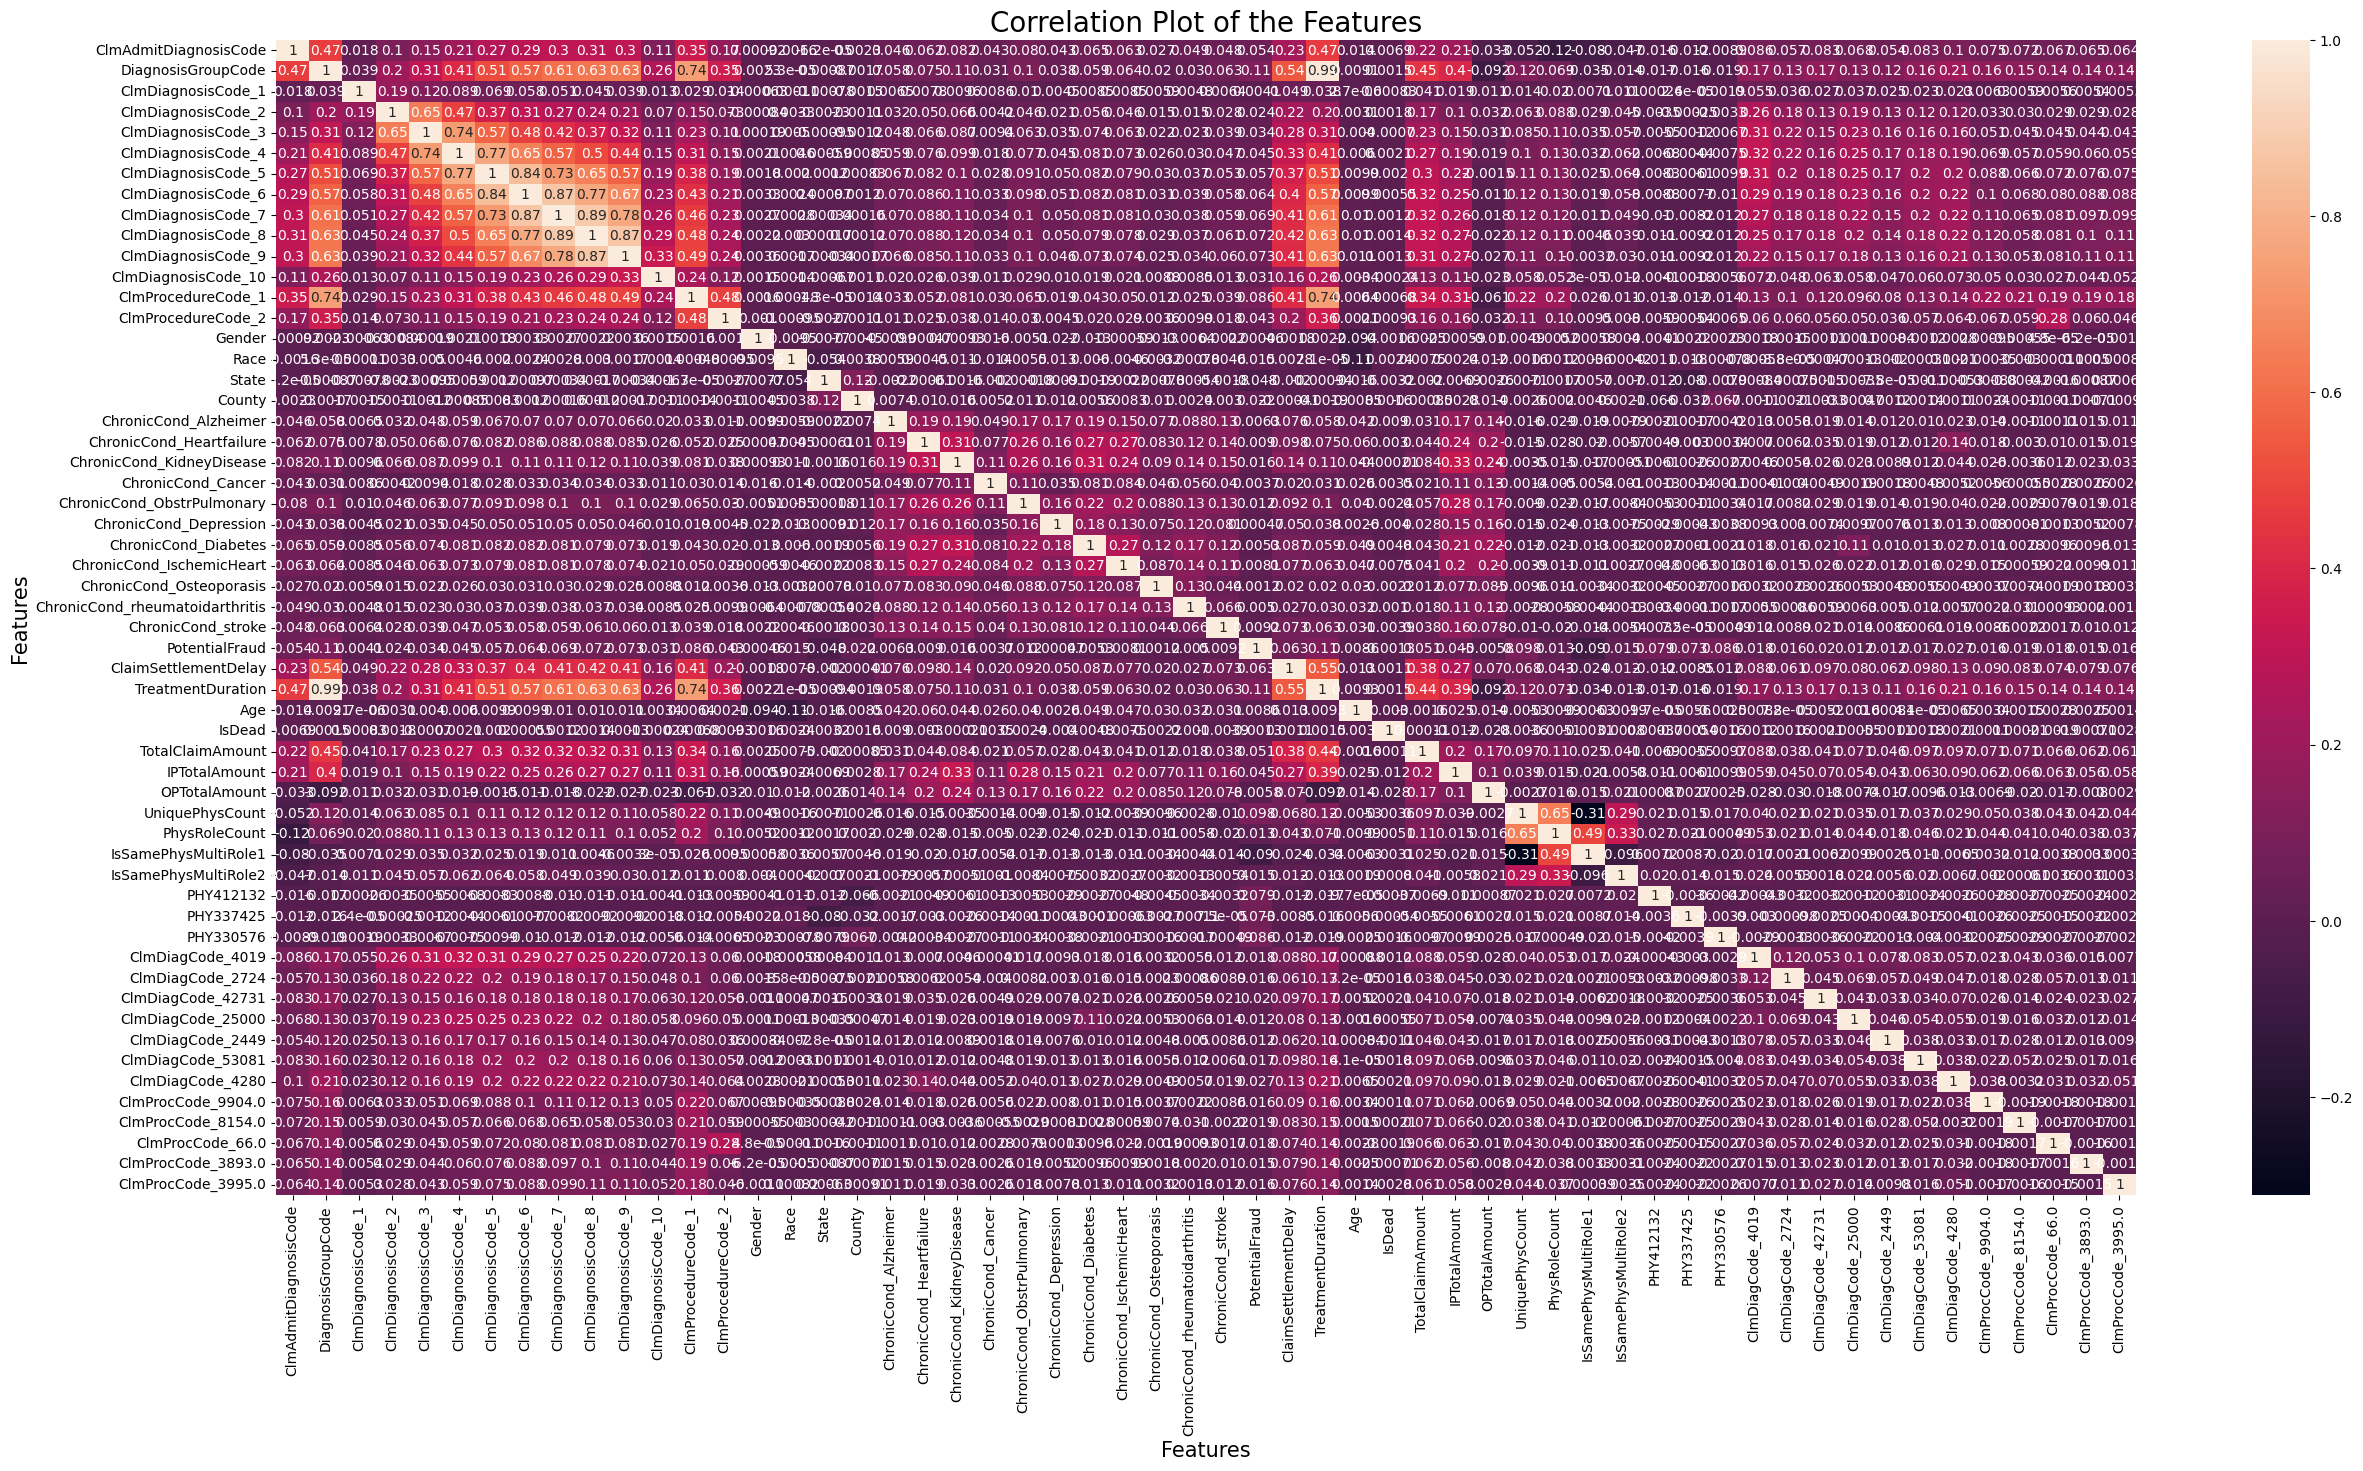

CPU times: total: 7.03 s
Wall time: 8.62 s


In [85]:
%%time
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

In [86]:
# Remove the above set of features from the dataset
data.drop(columns=['DiagnosisGroupCode', 'ClmProcedureCode_1', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                   'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
                ], inplace=True)

In [87]:
# Save the dataset
data.to_csv('Data/finalData.csv', index=False)

#### Observation

* As we can see that now no two features have a correlation coefficient greater than 0.70.
* This implies that there are no more highly correlated features (coefficient > 0.70).

In [89]:
# Display the features
data.columns # PotentialFraud is the Class Label here.

Index(['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_2',
       'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'PotentialFraud', 'ClaimSettlementDelay',
       'TreatmentDuration', 'Age', 'IsDead', 'TotalClaimAmount',
       'IPTotalAmount', 'OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount',
       'IsSamePhysMultiRole1', 'IsSamePhysMultiRole2', 'PHY412132',
       'PHY337425', 'PHY330576', 'ClmDiagCode_4019', 'ClmDiagCode_2724',
       'ClmDiagCode_42731', 'ClmDiagCode_25000', 'ClmDiagCode_2449',
       'ClmDiagCode_53081', 'ClmDiagCode_4280',